In [ ]:
# Mount Google Drive to access files stored in your Drive from Colab

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Package Installations

!pip install python-terrier
!pip install python-docx
!pip install gradio

In [ ]:
# Import Required Libraries

import pyterrier as pt
import os
import re
import pandas as pd
from docx import Document
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import gradio as gr
import numpy as np
import pytrec_eval

In [ ]:
# Initializes PyTerrier if it hasn't been started yet.

if not pt.started():
  pt.init()

In [ ]:
# Parses TREC-style documents from a folder of text files.
# Each <DOC> block is read and fields like DOCNO, FILEID, TEXT etc. are extracted.
# Returns a DataFrame containing all parsed documents.


def parse_docs_from_file(file_path):
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        content = f.read()
    docs = re.findall(r'<DOC>(.*?)</DOC>', content, re.DOTALL)
    parsed_docs = []

    for doc in docs:
        def extract(tag):
            pattern = f"<{tag}>(.*?)</{tag}>"
            match = re.search(pattern, doc, re.DOTALL)
            return match.group(1).strip() if match else None

        parsed_docs.append({
            "docno": extract("DOCNO"),
            "fileid": extract("FILEID"),
            "line1": extract("1ST_LINE"),
            "line2": extract("2ND_LINE"),
            "head": extract("HEAD"),
            "dateline": extract("DATELINE"),
            "text": extract("TEXT")
        })

    return parsed_docs

def parse_all_docs_from_folder(folder_path):
    all_docs = []
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            file_path = os.path.join(root, filename)
            all_docs.extend(parse_docs_from_file(file_path))
    return pd.DataFrame(all_docs)

In [ ]:
# Loads and parses all documents from the specified folder.
# Keeps only 'docno' and 'text' columns and drops rows with missing values.
# Prints the total number of documents.

folder_path = "/content/drive/MyDrive/AssociatedPressDataset/AP_collection/coll"

docs_df = parse_all_docs_from_folder(folder_path)
docs_df = docs_df[["docno", "text"]].dropna()

print("Total doc count:", len(docs_df))

Toplam belge sayısı: 79922


In [ ]:
# Preprocesses input text by lowercasing, removing punctuation, extra spaces, and stop words.

def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = text.split()
    tokens = [w for w in tokens if w not in ENGLISH_STOP_WORDS]
    return " ".join(tokens)

In [ ]:
# Applies text preprocessing to all documents in the 'text' column.

docs_df["text"] = docs_df["text"].apply(preprocess)

In [ ]:
# Indexes documents with PyTerrier

indexer = pt.IterDictIndexer("./pt_index_text_only")

index_ref = indexer.index((row for _, row in docs_df.iterrows()))
index = pt.IndexFactory.of(index_ref)

print("✔️ PyTerrier index created:", index)

In [ ]:
# Indexes documents with PyTerrier only if the index does not already exist.

if not os.path.exists("/content/drive/MyDrive/models/pt_index_text_only"):
    print("Index not found, creating new index...")
    indexer = pt.IterDictIndexer("/content/drive/MyDrive/models/pt_index_text_only")
    index_ref = indexer.index((row for _, row in docs_df.iterrows()))
else:
    print("Index exists, loading...")
    indexref = pt.IndexFactory.of("/content/drive/MyDrive/models/pt_index_text_only")

index = pt.IndexFactory.of(index_ref)

print("✔️ PyTerrier index created:", index)

Index exists, loading...
✔️ PyTerrier index created: <org.terrier.structures.Index at 0x78674a4ceed0 jclass=org/terrier/structures/Index jself=<LocalRef obj=0x32370878 at 0x78674b562610>>


In [ ]:
stats = index.getCollectionStatistics()
print("Number of Docs:", stats.getNumberOfDocuments())
print("Number of Tokens:", stats.getNumberOfTokens())
print("Number of Unique Terms:", stats.getNumberOfUniqueTerms())


Number of Docs: 79922
Number of Tokens: 17543101
Number of Unique Terms: 123306


In [ ]:
# Cleans multi-line text by removing extra whitespace and joining into a single line.

def clean_multiline(text):
    return " ".join(text.split()).strip()

In [ ]:
# Parses queries from a TREC-style .docx file and combines <title> and <desc> fields into a single query.

def parse_queries_title_desc(docx_path):
    document = Document(docx_path)
    full_text = "\n".join([p.text for p in document.paragraphs])
    blocks = re.findall(r"<top>(.*?)</top>", full_text, re.DOTALL)

    parsed_queries = []
    for block in blocks:
        num_match = re.search(r"<num>\s*(\d+)", block)
        title_match = re.search(r"<title>\s*(.+)", block)
        desc_match = re.search(r"<desc>\s*(.+?)(?=\n<narr>|$)", block, re.DOTALL)

        if num_match and title_match and desc_match:
            qid = num_match.group(1).strip()
            title = clean_multiline(title_match.group(1))
            desc = clean_multiline(desc_match.group(1)) if desc_match else ""
            combined_query = title + " " + desc
            parsed_queries.append({"qid": qid, "query": combined_query})

    return pd.DataFrame(parsed_queries)

In [ ]:
# Parses queries from a TREC-style .docx file using only the <title> field.

def parse_queries_title(docx_path):
    document = Document(docx_path)
    full_text = "\n".join([p.text for p in document.paragraphs])
    blocks = re.findall(r"<top>(.*?)</top>", full_text, re.DOTALL)

    parsed_queries = []
    for block in blocks:
        num_match = re.search(r"<num>\s*(\d+)", block)
        title_match = re.search(r"<title>\s*(.+)", block)

        if num_match and title_match:
            qid = num_match.group(1).strip()
            title = clean_multiline(title_match.group(1))
            parsed_queries.append({"qid": qid, "query": title})
            #print(f"[{qid}] {combined_query}")

    return pd.DataFrame(parsed_queries)

In [ ]:
# Sets Pandas display options for better visibility, then parses queries with and without descriptions from a .docx file.

pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 300)
pd.set_option('display.max_rows', None)


queries_df_desc = parse_queries_title_desc("/content/drive/MyDrive/AssociatedPressDataset/topics1-50.docx")
queries_df_only_title = parse_queries_title("/content/drive/MyDrive/AssociatedPressDataset/topics1-50.docx")

In [ ]:
# Applies text preprocessing to queries (with and without descriptions).

queries_df_desc["query"] = queries_df_desc["query"].apply(preprocess)
queries_df_only_title["query"] = queries_df_only_title["query"].apply(preprocess)

In [ ]:
# Initializes a BM25 retriever to fetch the top 100 documents for each query using the built index.

bm25 = pt.BatchRetrieve(index, wmodel="BM25", num_results=100)


<ipython-input-30-ecb40d84f14d>:2: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25 = pt.BatchRetrieve(index, wmodel="BM25", num_results=100)


In [ ]:
# Parses relevance judgments (qrels) from a .docx file into a DataFrame.

def parse_qrels_from_docx(docx_path):
    doc = Document(docx_path)
    lines = [p.text.strip() for p in doc.paragraphs if re.match(r'^\d+ +0 +AP.*? +[01]$', p.text.strip())]

    parsed = []
    for line in lines:
        parts = line.split()
        if len(parts) == 4:
            qid, iter_, docno, rel = parts
            parsed.append({
                "qid": str(qid),
                "docno": docno,
                "relevance": int(rel)
            })
    return pd.DataFrame(parsed)

In [ ]:
# Parses qrels from the .docx file (249 pages: 44 entries per page, 25 on the last page) and prints the total number of relevance judgments.

qrels = parse_qrels_from_docx("/content/drive/MyDrive/AssociatedPressDataset/qrels1-50ap.docx")

print(len(qrels))

10937


In [ ]:
#Find best parameters for query with description
best_score = 0
best_config = None

for k1 in [0.6, 0.9, 1.2, 1.5]:
    for b in [0.3, 0.5, 0.75, 0.9]:
        print(f"Testing k1={k1}, b={b}")
        bm25_tuned = pt.BatchRetrieve(index, wmodel="BM25", num_results=100,
                                      controls={"bm25.k_1": str(k1), "bm25.b": str(b)})

        result = pt.Experiment(
            [bm25_tuned],
            queries_df_desc,
            qrels,
            eval_metrics=["map"],
            names=[f"k1={k1}, b={b}"]
        )

        current_score = result["map"][0]
        print(f"MAP = {current_score:.4f}")

        if current_score > best_score:
            best_score = current_score
            best_config = (k1, b)

print(f"\nBest config: k1={best_config[0]}, b={best_config[1]} with MAP = {best_score:.4f}")
#best k=1.5 and b=0.5

In [ ]:
#Find best parameters for query without description
best_score = 0
best_config = None

for k1 in [0.6, 0.9, 1.2, 1.5]:
    for b in [0.3, 0.5, 0.75, 0.9]:
        print(f"Testing k1={k1}, b={b}")
        bm25_tuned = pt.BatchRetrieve(index, wmodel="BM25", num_results=100,
                                      controls={"bm25.k_1": str(k1), "bm25.b": str(b)})

        result = pt.Experiment(
            [bm25_tuned],
            queries_df_only_title,
            qrels,
            eval_metrics=["map"],
            names=[f"k1={k1}, b={b}"]
        )

        current_score = result["map"][0]
        print(f"MAP = {current_score:.4f}")

        if current_score > best_score:
            best_score = current_score
            best_config = (k1, b)

print(f"\nBest config: k1={best_config[0]}, b={best_config[1]} with MAP = {best_score:.4f}")
#best k=1.5 and b=0.3

In [ ]:
# Initializes a BM25 retriever for desc (with best parameters) to retrieve top 100 documents per query using the index

bm25_best_for_with_desc = pt.BatchRetrieve(index, wmodel="BM25", num_results=100, controls={"bm25.k_1": "1.5", "bm25.b": "0.5"})

<ipython-input-37-48bb48300585>:3: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25_best_for_with_desc = pt.BatchRetrieve(index, wmodel="BM25", num_results=100, controls={"bm25.k_1": "1.5", "bm25.b": "0.5"})


In [ ]:
# Initializes a BM25 retriever for only title (with best parameters) to retrieve top 100 documents per query using the index

bm25_best_for_only_title = pt.BatchRetrieve(index, wmodel="BM25", num_results=100, controls={"bm25.k_1": "1.5", "bm25.b": "0.3"})

<ipython-input-38-02c1beb95f88>:3: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25_best_for_only_title = pt.BatchRetrieve(index, wmodel="BM25", num_results=100, controls={"bm25.k_1": "1.5", "bm25.b": "0.3"})


In [ ]:
# Evaluates the BM25 retriever (with title + description queries) using qrels and standard IR metrics.


eval = pt.Experiment(
    [bm25],
    topics=queries_df_desc,
    qrels=qrels,
    eval_metrics=["map", "P.10", "recall.100", "ndcg"],
    names=["BM25"]
)

print(eval)

   name       map   P.10  recall.100      ndcg
0  BM25  0.295927  0.452    0.608792  0.504574


In [ ]:
# Evaluates the tuned BM25 retriever (with title + description queries) using qrels and standard IR metrics.


eval = pt.Experiment(
    [bm25_best_for_with_desc],
    topics=queries_df_desc,
    qrels=qrels,
    eval_metrics=["map", "P.10", "recall.100", "ndcg"],
    names=["BM25"]
)

print(eval)

   name       map   P.10  recall.100      ndcg
0  BM25  0.301375  0.456    0.613607  0.508126


In [ ]:
# Evaluates the BM25 retriever (only title queries) using qrels and standard IR metrics.

eval = pt.Experiment(
    [bm25],
    topics=queries_df_only_title,      # qid + query içeren DF
    qrels=qrels,            # qid + docno + relevance
    eval_metrics=["map", "P.10", "recall.100", "ndcg"],
    names=["BM25"]
)

print(eval)

   name       map   P.10  recall.100      ndcg
0  BM25  0.250704  0.396    0.525112  0.434295


In [ ]:
# Evaluates the tuned BM25 retriever (only title queries) using qrels and standard IR metrics.

eval = pt.Experiment(
    [bm25_best_for_only_title],
    topics=queries_df_only_title,      # qid + query içeren DF
    qrels=qrels,            # qid + docno + relevance
    eval_metrics=["map", "P.10", "recall.100", "ndcg"],
    names=["BM25"]
)

print(eval)

   name      map  P.10  recall.100      ndcg
0  BM25  0.26011  0.41    0.539969  0.446874


In [ ]:
# Prints the top 10 retrieved documents for a given query ID index from the result DataFrame.

def printTopKDoc(qid_index, query):
    first_qid = queries_df_only_title.iloc[qid_index]["qid"]
    first_query_docs = query[
        query["qid"] == first_qid
    ]
    print(f"🔍 Sorgu ID (qid): {first_qid} — Top 10 Döküman\n{'='*60}")
    for i, row in first_query_docs.iterrows():
        print(f"\n📄 Docno: {row['docno']}")
        print(f"🔎 QID: {row['qid']}")
        print("-" * 60)



In [ ]:
# For each only-title query, retrieves top-10 documents using both default and tuned BM25, then stores and combines the results into two DataFrames.

default_all_top10_docs_only_title = []
tuned_all_top10_docs_only_title = []

for i, row in queries_df_only_title.iterrows():
    qid = row["qid"]
    query_text = row["query"]

    # Creates a single-row DataFrame with 'qid' and 'query' columns for use with PyTerrier.
    query_df = pd.DataFrame([{"qid": qid, "query": query_text}])

    # Rank documents using BM25
    default_results = bm25.transform(query_df)
    tuned_results = bm25_best_for_only_title.transform(query_df)

    # Get the docno of the top 10 retrieved documents
    default_top_docnos = default_results.head(10)["docno"].tolist()
    tuned_top_docnos = tuned_results.head(10)["docno"].tolist()

    # Retrieve the documents from `docs_df` that match the selected docnos
    default_top_docs_df = docs_df[docs_df["docno"].isin(default_top_docnos)].copy()
    tuned_top_docs_df = docs_df[docs_df["docno"].isin(tuned_top_docnos)].copy()

    # Assign the corresponding query ID to each retrieved document
    default_top_docs_df["qid"] = qid
    tuned_top_docs_df["qid"] = qid

    # Append the results to the list
    default_all_top10_docs_only_title.append(default_top_docs_df)
    tuned_all_top10_docs_only_title.append(tuned_top_docs_df)

# Combine the top-10 results of all queries (e.g., 50 queries × 10 docs = 500 rows)
default_top10_df_all_queries_only_title = pd.concat(default_all_top10_docs_only_title, ignore_index=True)
tuned_top10_df_all_queries_only_title = pd.concat(tuned_all_top10_docs_only_title, ignore_index=True)



In [ ]:
# Prints the top 10 retrieved documents for the first query using both default and tuned BM25.

printTopKDoc(0,default_top10_df_all_queries_only_title)
print("-" * 100)
printTopKDoc(0,tuned_top10_df_all_queries_only_title)

In [ ]:
# For each query with title + description, retrieves top-10 documents using both default and tuned BM25, then stores and combines the results into two DataFrames.

default_all_top10_docs_with_desc = []
tuned_all_top10_docs_with_desc = []

for i, row in queries_df_desc.iterrows():
    qid = row["qid"]
    query_text = row["query"]

    # Creates a single-row DataFrame with 'qid' and 'query' columns for use with PyTerrier.
    query_df = pd.DataFrame([{"qid": qid, "query": query_text}])

    # Rank documents using BM25
    default_results = bm25.transform(query_df)
    tuned_results = bm25_best_for_with_desc.transform(query_df)

    # Get the docno of the top 10 retrieved documents
    default_top_docnos = default_results.head(10)["docno"].tolist()
    tuned_top_docnos = tuned_results.head(10)["docno"].tolist()

    # Retrieve the documents from `docs_df` that match the selected docnos
    default_top_docs_df = docs_df[docs_df["docno"].isin(default_top_docnos)].copy()
    tuned_top_docs_df = docs_df[docs_df["docno"].isin(tuned_top_docnos)].copy()

    # Assign the corresponding query ID to each retrieved document
    default_top_docs_df["qid"] = qid
    tuned_top_docs_df["qid"] = qid

    # Append the results to the list
    default_all_top10_docs_with_desc.append(default_top_docs_df)
    tuned_all_top10_docs_with_desc.append(tuned_top_docs_df)

# Combine the top-10 results of all queries (e.g., 50 queries × 10 docs = 500 rows)
default_top10_df_all_queries_with_desc = pd.concat(default_all_top10_docs_with_desc, ignore_index=True)
tuned_top10_df_all_queries_with_desc = pd.concat(tuned_all_top10_docs_with_desc, ignore_index=True)

In [ ]:
# Prints the top 10 retrieved documents for the first query using both default and tuned BM25.

printTopKDoc(0,default_top10_df_all_queries_with_desc)
print("-" * 100)
printTopKDoc(0,tuned_top10_df_all_queries_with_desc)

In [ ]:
# optional
# Install required NLP libraries if not exists in directoy: SentenceTransformers and spaCy

!pip install -q sentence-transformers
!pip install -q spacy
!python -m spacy download en_core_web_sm

In [ ]:
# Import libraries for SBERT embeddings (SentenceTransformer, torch) and sentence segmentation (spaCy)

import torch

from sentence_transformers import SentenceTransformer, util
import spacy

In [ ]:
# Load Sbert from previously saved model
SBERT_PATH = "/content/drive/MyDrive/models/sbert_all-MiniLM-L6-v2"
SPACY_PATH = "/content/drive/MyDrive/models/en_core_web_sm"

# Load or install SBERT model
if os.path.exists(SBERT_PATH):
    print("✅ Loading SBERT model from Drive...")
    sbert_model = SentenceTransformer(SBERT_PATH)
else:
    print("⬇️  SBERT model not found, downloading...")
    %pip install -q sentence-transformers
    sbert_model = SentenceTransformer("all-MiniLM-L6-v2")
    sbert_model.save(SBERT_PATH)
    print("✅ SBERT model saved to Drive.")

# Load or install spaCy model
if os.path.exists(SPACY_PATH):
    print("✅ Loading spaCy model from Drive...")
    !cp -r "$SPACY_PATH" /usr/local/lib/python3.*/dist-packages/
else:
    print("⬇️  spaCy model not found, downloading...")
    %pip install -q spacy
    !python -m spacy download en_core_web_sm
    !cp -r /usr/local/lib/python3.*/dist-packages/en_core_web_sm "$SPACY_PATH"
    print("✅ spaCy model saved to Drive.")

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")
print("✅ spaCy model loaded.")

In [ ]:
# Splits input text into sentences using spaCy's sentence segmentation.

def get_sentences_spacy(text):
    doc = nlp(text)
    return [sent.text.strip() for sent in doc.sents]


In [ ]:
# Retrieves the top-k most similar sentences to the query from a set of documents using SBERT cosine similarity.

def get_top_similar_sentences(query_text, doc_df, top_k=5):
    sentences = []

    for doc in doc_df["text"]:
        doc_sentences = get_sentences_spacy(doc)
        sentences.extend(doc_sentences)

    if not sentences:
        return []

    query_embedding = sbert_model.encode(query_text, convert_to_tensor=True)
    sentence_embeddings = sbert_model.encode(sentences, convert_to_tensor=True)

    cos_scores = util.cos_sim(query_embedding, sentence_embeddings)[0]
    top_results = torch.topk(cos_scores, k=min(top_k, len(sentences)))

    best_sentences = [sentences[i] for i in top_results.indices]
    return best_sentences



In [ ]:
# For each query, finds the top-k most semantically similar sentences from its top-10 documents using SBERT.

def extract_top_semantic_sentences_for_all_queries(queries_df, top10_df, top_k_sent=5):
    """
    Return: List of dicts: {"qid": ..., "query": ..., "sentences": [...]}
    """
    results = []

    for _, row in queries_df.iterrows():
        qid = row["qid"]
        query_text = row["query"]

        top_docs_df = top10_df[top10_df["qid"] == qid]

        best_sentences = get_top_similar_sentences(query_text, top_docs_df, top_k=top_k_sent)

        results.append({
            "qid": qid,
            "query": query_text,
            "sentences": best_sentences
        })

    return results



In [ ]:
# Extracts top-5 semantically similar sentences for each only-title query from default and tuned BM25 results.

semantic_sentences_default_only_title = extract_top_semantic_sentences_for_all_queries(
    queries_df=queries_df_only_title,
    top10_df=default_top10_df_all_queries_only_title,
    top_k_sent=5
)

semantic_sentences_tuned_only_title = extract_top_semantic_sentences_for_all_queries(
    queries_df=queries_df_only_title,
    top10_df=tuned_top10_df_all_queries_only_title
)

In [ ]:
# Extracts top semantically similar sentences for each title+description query from default and tuned BM25 results.

semantic_sentences_default_with_desc = extract_top_semantic_sentences_for_all_queries(
    queries_df=queries_df_desc,
    top10_df=default_top10_df_all_queries_with_desc
)

semantic_sentences_tuned_with_desc = extract_top_semantic_sentences_for_all_queries(
    queries_df=queries_df_desc,
    top10_df=tuned_top10_df_all_queries_with_desc
)

In [1]:
# Prints query texts and their top semantically similar sentences for the first few queries in the list.

def print_semantic_sentences(semantic_list, title="", num_queries=3):
    print(f"\n{'='*25} {title.upper()} {'='*25}")
    for i in range(min(num_queries, len(semantic_list))):
        item = semantic_list[i]
        print(f"\n🔍 QID: {item['qid']} — Query: {item['query']}")
        for j, sent in enumerate(item["sentences"], 1):
            print(f"{j}. {sent}")
        print("=" * 80)


In [ ]:
# Prints top semantic sentences for the first 3 queries from default and tuned BM25 results (only-title queries).

print_semantic_sentences(semantic_sentences_default_only_title, "Default Only Title", num_queries=3)
print_semantic_sentences(semantic_sentences_tuned_only_title, "Tuned With Desc", num_queries=3)

In [ ]:
# Prints top semantic sentences for the first 3 queries from default and tuned BM25 results (title + description queries).

print_semantic_sentences(semantic_sentences_default_with_desc, "Default Only Title", num_queries=3)
print_semantic_sentences(semantic_sentences_tuned_with_desc, "Tuned With Desc", num_queries=3)

In [ ]:
# Install KeyBERT for keyword extraction

!pip install -q keybert


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.5 MB/s eta 0:00:00


In [ ]:
# Import KeyBERT and initialize it with the pre-loaded SBERT model.

from keybert import KeyBERT

keybert_model = KeyBERT(model=sbert_model)


In [ ]:
# Extracts top-n meaningful keywords from a list of sentences using KeyBERT.

def extract_keywords_from_sentences(sentences, top_n=5):
    combined_text = " ".join(sentences)
    keywords = keybert_model.extract_keywords(combined_text, keyphrase_ngram_range=(1, 2), stop_words='english', top_n=top_n)
    return [kw[0] for kw in keywords]


In [ ]:
# Generates query expansions by extracting keywords from semantically similar sentences for all queries.

def generate_query_expansions(semantic_sentences_all_queries, top_n_keywords=5):
    expansions = []

    for item in semantic_sentences_all_queries:
        qid = item["qid"]
        query = item["query"]
        sentences = item["sentences"]

        keywords = extract_keywords_from_sentences(sentences, top_n=top_n_keywords)

        expansions.append({
            "qid": qid,
            "original_query": query,
            "expanded_terms": keywords,
        })

    return expansions


In [ ]:
# Expansions only title
expansions_default_only_title = generate_query_expansions(
    semantic_sentences_default_only_title,
    top_n_keywords=5
)

expansions_tuned_only_title = generate_query_expansions(
    semantic_sentences_tuned_only_title,
    top_n_keywords=5
)

In [ ]:
# Expansions title and desc
expansions_default_with_desc = generate_query_expansions(
    semantic_sentences_default_with_desc,
    top_n_keywords=5
)


expansions_tuned_with_desc = generate_query_expansions(
    semantic_sentences_tuned_with_desc,
    top_n_keywords=5
)

In [ ]:
# Prints the first three query expansions with their original queries and expanded terms.

def print_query_expansions(expansions_list, title):
    print(f"\n{'='*20} {title} {'='*20}")
    for exp in expansions_list[:3]:
        print(f"\n🔍 QID: {exp['qid']}")
        print(f"🧠 Original Query: {exp['original_query']}")
        print(f"➕ Expanded Terms: {exp['expanded_terms']}")


In [ ]:
print_query_expansions(expansions_default_only_title, "DEFAULT — ONLY TITLE")
print_query_expansions(expansions_tuned_only_title, "TUNED — ONLY TITLE")

In [ ]:
print_query_expansions(expansions_default_with_desc, "DEFAULT — WITH DESC")
print_query_expansions(expansions_tuned_with_desc, "TUNED — WITH DESC")

In [ ]:
# Cleans duplicate and similar keyword phrases; optionally removes single-word phrases.

def clean_expansion_terms(phrases, remove_single_word=True):
    """
    Tekrar eden ve benzer kelime kombinasyonuna sahip phrase'leri temizler.
    Example: 'insurance coverage' and 'coverage insurance' -> one of them keeps
    """
    seen = set()
    cleaned = []
    for phrase in phrases:
        key = tuple(sorted(phrase.lower().split()))
        if key not in seen:
            seen.add(key)
            cleaned.append(phrase)

    # İstenirse tek kelimelik terimleri çıkar
    if remove_single_word:
        cleaned = [p for p in cleaned if len(p.strip().split()) > 1]

    return cleaned


In [ ]:
# Expands the original query by appending cleaned and limited duplicate expansion terms.

def expand_query(original_query, expansion_terms):
    expansion_text = limit_term_duplicates(expansion_terms)
    expanded_query = f"{original_query} {expansion_text}"

    return expanded_query.strip()




In [ ]:
# Limits the occurrences of each expansion term to a maximum count to avoid over-repetition.

from collections import Counter

def limit_term_duplicates(expansion_terms, max_occurrences=2):
    # Flatten phrases into words
    all_tokens = " ".join(expansion_terms).split()
    counts = Counter()
    filtered_tokens = []

    for token in all_tokens:
        if counts[token] < max_occurrences:
            filtered_tokens.append(token)
            counts[token] += 1

    return " ".join(filtered_tokens)


In [ ]:
def build_expanded_query(original_query, expanded_terms):
    return f'{original_query} OR ' + " OR ".join(expanded_terms)


In [ ]:
def update_all_expansions_with_query(expansion_lists):
    for expansion_list in expansion_lists:
        for item in expansion_list:
            query = item["original_query"]
            keywords = item["expanded_terms"]
            item["expanded_query"] = expand_query(query, keywords) #build_expanded_query(query, keywords)


In [ ]:
update_all_expansions_with_query([
    expansions_default_only_title,
    expansions_tuned_only_title,
])


In [ ]:
update_all_expansions_with_query([
    expansions_default_with_desc,
    expansions_tuned_with_desc
])

In [ ]:
def print_query_expansions(expansions_list, title):
    print(f"\n{'='*20} {title} {'='*20}")
    for exp in expansions_list[:3]:
        print(f"\n🔍 QID: {exp['qid']}")
        print(f"🧠 Original Query: {exp['original_query']}")
        print(f"➕ Expanded Terms: {exp['expanded_terms']}")
        print(f"➕ Expanded Query: {exp['expanded_query']}")

In [ ]:
print_query_expansions(expansions_default_only_title, "DEFAULT — ONLY TITLE")
print_query_expansions(expansions_tuned_only_title, "TUNED — ONLY TITLE")

In [ ]:
print_query_expansions(expansions_default_with_desc, "DEFAULT — WITH DESC")
print_query_expansions(expansions_tuned_with_desc, "TUNED — WITH DESC")

In [ ]:
# 1. Default BM25 + only_title expanded
df_exp_default_only_title = pd.DataFrame([
    {"qid": item["qid"], "query": item["expanded_query"]}
    for item in expansions_default_only_title
])

# 2. Tuned BM25 + only_title expanded
df_exp_tuned_only_title = pd.DataFrame([
    {"qid": item["qid"], "query": item["expanded_query"]}
    for item in expansions_tuned_only_title
])

In [ ]:

# 3. Default BM25 + with_desc expanded
df_exp_default_with_desc = pd.DataFrame([
    {"qid": item["qid"], "query": item["expanded_query"]}
    for item in expansions_default_with_desc
])

# 4. Tuned BM25 + with_desc expanded
df_exp_tuned_with_desc = pd.DataFrame([
    {"qid": item["qid"], "query": item["expanded_query"]}
    for item in expansions_tuned_with_desc
])


In [ ]:
# Evaluates the BM25 retriever (only expanded title queries) using qrels and standard IR metrics.

eval = pt.Experiment(
    [bm25],
    topics=df_exp_default_only_title,
    qrels=qrels,
    eval_metrics=["map", "P.10", "recall.100", "ndcg"],
    names=["BM25"]
)

print(eval)

   name       map  P.10  recall.100      ndcg
0  BM25  0.265549  0.39    0.519095  0.443074


In [ ]:
# Evaluates the tuned BM25 retriever (only expanded title queries) using qrels and standard IR metrics.

eval = pt.Experiment(
    [bm25_best_for_only_title],
    topics=df_exp_tuned_only_title,
    qrels=qrels,
    eval_metrics=["map", "P.10", "recall.100", "ndcg"],
    names=["BM25"]
)

print(eval)

   name       map   P.10  recall.100      ndcg
0  BM25  0.276782  0.408    0.511983  0.453036


In [ ]:
# Evaluates the BM25 retriever (expanded title and desc queries) using qrels and standard IR metrics.

eval = pt.Experiment(
    [bm25],
    topics=df_exp_default_with_desc,
    qrels=qrels,
    eval_metrics=["map", "P.10", "recall.100", "ndcg"],
    names=["BM25"]
)

print(eval)

   name       map   P.10  recall.100      ndcg
0  BM25  0.325146  0.436     0.62471  0.535099


In [ ]:
# Evaluates the tunedBM25 retriever (expanded title and desc queries) using qrels and standard IR metrics.

eval = pt.Experiment(
    [bm25_best_for_with_desc],
    topics=df_exp_tuned_with_desc,
    qrels=qrels,
    eval_metrics=["map", "P.10", "recall.100", "ndcg"],
    names=["BM25"]
)

print(eval)

   name       map  P.10  recall.100     ndcg
0  BM25  0.320018  0.44    0.624196  0.53306


In [ ]:
# Expands queries by extracting top TF-IDF keywords from their top semantic sentences.

from sklearn.feature_extraction.text import TfidfVectorizer

def expand_queries_tfidf(semantic_list, top_k_terms=5):
    expanded = []

    for item in semantic_list:
        qid = item["qid"]
        original_query = item["query"]
        sentences = item["sentences"]

        tfidf = TfidfVectorizer(stop_words='english', max_features=100)
        X = tfidf.fit_transform(sentences)
        feature_array = tfidf.get_feature_names_out()

        summed_tfidf = X.sum(axis=0).A1
        top_indices = summed_tfidf.argsort()[::-1][:top_k_terms]
        top_keywords = [feature_array[i] for i in top_indices]

        # Expand query
        expanded_query = original_query + " " + " ".join(top_keywords)
        expanded.append({
            "qid": qid,
            "original_query": original_query,
            "expanded_query": expanded_query,
            "keywords_added": top_keywords
        })

    return expanded


In [ ]:
# Get top 10 most similar sentences with SBERT
semantic_sentences_default_only_title_10s = extract_top_semantic_sentences_for_all_queries(
    queries_df=queries_df_only_title,
    top10_df=default_top10_df_all_queries_only_title,
    top_k_sent=10
)

semantic_sentences_tuned_only_title_10s = extract_top_semantic_sentences_for_all_queries(
    queries_df=queries_df_only_title,
    top10_df=tuned_top10_df_all_queries_only_title,
    top_k_sent=10
)

In [ ]:
#Expand queries by choosing expansion terms with TF-IDF from SBERT sentences for parameter tuned BM25
sbert_exp_tuned_only_title_tfidf = expand_queries_tfidf(semantic_sentences_tuned_only_title_10s)

for item in sbert_exp_tuned_only_title_tfidf[:3]:
    print(f"\n🔍 QID: {item['qid']}")
    print(f"Original : {item['original_query']}")
    print(f"Expanded : {item['expanded_query']}")
    print(f"Keywords : {item['keywords_added']}")


In [ ]:
#Expand queries by choosing expansion terms with TF-IDF from SBERT sentences for default BM25
sbert_exp_default_only_title_tfidf = expand_queries_tfidf(semantic_sentences_default_only_title_10s)

for item in sbert_exp_default_only_title_tfidf[:3]:
    print(f"\n🔍 QID: {item['qid']}")
    print(f"Original : {item['original_query']}")
    print(f"Expanded : {item['expanded_query']}")
    print(f"Keywords : {item['keywords_added']}")


In [ ]:
#Run parameter tuned BM25 with expanded queries

df_sbert_exp_tuned_only_title_tfidf = pd.DataFrame([
    {"qid": item["qid"], "query": item["expanded_query"]}
    for item in sbert_exp_tuned_only_title_tfidf  # output of expand_queries_tfidf()
])
eval = pt.Experiment(
    [bm25_best_for_only_title],
    topics=df_sbert_exp_tuned_only_title_tfidf,      # qid + query içeren DF
    qrels=qrels,            # qid + docno + relevance
    eval_metrics=["map", "P.10", "recall.100", "ndcg"],
    names=["BM25"]
)

print(eval)

   name       map   P.10  recall.100      ndcg
0  BM25  0.290716  0.434    0.544269  0.468388


In [ ]:
#Run default BM25 with expanded queries

df_sbert_exp_default_only_title_tfidf = pd.DataFrame([
    {"qid": item["qid"], "query": item["expanded_query"]}
    for item in sbert_exp_default_only_title_tfidf  # output of expand_queries_tfidf()
])
eval = pt.Experiment(
    [bm25],
    topics=df_sbert_exp_default_only_title_tfidf,      # qid + query içeren DF
    qrels=qrels,            # qid + docno + relevance
    eval_metrics=["map", "P.10", "recall.100", "ndcg"],
    names=["BM25"]
)

print(eval)

   name       map   P.10  recall.100      ndcg
0  BM25  0.279171  0.428    0.518044  0.445057


In [ ]:
# Expands queries by extracting top TF-IDF keywords from their top-10 retrieved documents.

from sklearn.feature_extraction.text import TfidfVectorizer

def expand_queries_with_tfidf_from_top10(queries_df, top10_df, top_k_terms=5):
    results = []

    for _, row in queries_df.iterrows():
        qid = row["qid"]
        query_text = row["query"]
        original_tokens = set(query_text.lower().split())

        # Get top-10 docs for that query
        doc_df = top10_df[top10_df["qid"] == qid]
        documents = doc_df["text"].dropna().tolist()  # field = "text", "title", etc.

        if not documents:
            results.append({
                "qid": qid,
                "query": query_text,
                "expanded_query": query_text,
                "keywords_added": []
            })
            continue

        # TF-IDF on top-10 docs' texts
        tfidf = TfidfVectorizer(stop_words="english", max_features=100)
        X = tfidf.fit_transform(documents)
        feature_array = tfidf.get_feature_names_out()
        summed_tfidf = X.sum(axis=0).A1

        top_indices = summed_tfidf.argsort()[::-1][:top_k_terms]
        top_keywords = [feature_array[i] for i in top_indices]

        # Expand query
        expanded_query = query_text + " " + " ".join(top_keywords)
        results.append({
            "qid": qid,
            "query": query_text,
            "expanded_query": expanded_query,
            "keywords_added": top_keywords
        })

    return results


In [ ]:
#Expand queries by choosing expansion terms with TF-IDF from top 10 retrieved docs for parameter tuned BM25
exp_tuned_only_title_only_tfidf = expand_queries_with_tfidf_from_top10(
    queries_df=queries_df_only_title,
    top10_df=tuned_top10_df_all_queries_only_title,
    top_k_terms=5
)


for item in exp_tuned_only_title_only_tfidf[:3]:
    print(f"\n🔍 QID: {item['qid']}")
    print(f"Original Query : {item['query']}")
    print(f"Expanded Query : {item['expanded_query']}")
    print(f"Added Keywords : {item['keywords_added']}")


In [ ]:
#Expand queries by choosing expansion terms with TF-IDF from top 10 retrieved docs for default BM25

exp_default_only_title_only_tfidf = expand_queries_with_tfidf_from_top10(
    queries_df=queries_df_only_title,
    top10_df=default_top10_df_all_queries_only_title,
    top_k_terms=5
)


for item in exp_default_only_title_only_tfidf[:3]:
    print(f"\n🔍 QID: {item['qid']}")
    print(f"Original Query : {item['query']}")
    print(f"Expanded Query : {item['expanded_query']}")
    print(f"Added Keywords : {item['keywords_added']}")


In [ ]:
#Run parameter tuned BM25 with expanded queries

df_exp_tuned_only_title_only_tfidf = pd.DataFrame([
    {"qid": item["qid"], "query": item["expanded_query"]}
    for item in exp_tuned_only_title_only_tfidf  # output of expand_queries_tfidf()
])
eval = pt.Experiment(
    [bm25_best_for_only_title],
    topics=df_exp_tuned_only_title_only_tfidf,      # qid + query içeren DF
    qrels=qrels,            # qid + docno + relevance
    eval_metrics=["map", "P.10", "recall.100", "ndcg"],
    names=["BM25"]
)

print(eval)

   name      map   P.10  recall.100      ndcg
0  BM25  0.29017  0.426    0.564452  0.476746


In [ ]:
#Run default BM25 with expanded queries

df_exp_default_only_title_only_tfidf= pd.DataFrame([
    {"qid": item["qid"], "query": item["expanded_query"]}
    for item in exp_default_only_title_only_tfidf  # output of expand_queries_tfidf()
])
eval = pt.Experiment(
    [bm25],
    topics=df_exp_default_only_title_only_tfidf,      # qid + query içeren DF
    qrels=qrels,            # qid + docno + relevance
    eval_metrics=["map", "P.10", "recall.100", "ndcg"],
    names=["BM25"]
)

print(eval)

   name       map   P.10  recall.100      ndcg
0  BM25  0.288468  0.426    0.549451  0.471048


In [ ]:
# KeyBert query expansion with 10 sentences retrieved with SBERT
expansions_default_only_title_10s = generate_query_expansions(
    semantic_sentences_default_only_title_10s,
    top_n_keywords=5
)

expansions_tuned_only_title_10s = generate_query_expansions(
    semantic_sentences_tuned_only_title_10s,
    top_n_keywords=5
)
update_all_expansions_with_query([
    expansions_default_only_title_10s,
    expansions_tuned_only_title_10s
])

In [ ]:
print_query_expansions(expansions_default_only_title_10s, "DEFAULT — ONLY TITLE")
print_query_expansions(expansions_tuned_only_title_10s, "TUNED — ONLY TITLE")

In [ ]:
#Put query expansion results in DataFrame
df_exp_default_only_title_ten_sentences = pd.DataFrame([
    {"qid": item["qid"], "query": item["expanded_query"]}
    for item in expansions_default_only_title_10s
])

df_exp_tuned_only_title_ten_sentences = pd.DataFrame([
    {"qid": item["qid"], "query": item["expanded_query"]}
    for item in expansions_tuned_only_title_10s
])

In [ ]:
#Run parameter tuned BM25 with expanded queries
eval = pt.Experiment(
    [bm25_best_for_only_title],
    topics=df_exp_tuned_only_title_ten_sentences,      # qid + query içeren DF
    qrels=qrels,            # qid + docno + relevance
    eval_metrics=["map", "P.10", "recall.100", "ndcg"],
    names=["BM25"]
)

print(eval)

   name       map  P.10  recall.100      ndcg
0  BM25  0.281266  0.42    0.522922  0.459968


In [ ]:
#Run default BM25 with expanded queries
eval = pt.Experiment(
    [bm25],
    topics=df_exp_default_only_title_ten_sentences,      # qid + query içeren DF
    qrels=qrels,            # qid + docno + relevance
    eval_metrics=["map", "P.10", "recall.100", "ndcg"],
    names=["BM25"]
)

print(eval)

   name       map   P.10  recall.100      ndcg
0  BM25  0.264243  0.402    0.522616  0.443722


In [ ]:
# Interface with Gradio
import gradio as gr
import pandas as pd
import pytrec_eval

qrels_dict = {(str(row.qid), row.docno): int(row.relevance) for _, row in qrels.iterrows()}
def get_doc_preview(docno): return doc_preview_dict.get(docno, "N/A")
doc_preview_dict = docs_df.set_index("docno")["text"].apply(lambda t: " ".join(t.split()[:10]) + " ...").to_dict()

#Method for querying with test queries
def evaluate_test_query_with_prf(qid, method):
    qid = str(qid)
    query_text = queries_df_only_title[queries_df_only_title["qid"] == qid]["query"].values[0]

    if method == "BM25 only":
        expanded_query = query_text
        expanded_terms = []
    elif method == "TF-IDF PRF":
        item = exp_tuned_only_title_only_tfidf.get(qid)
        expanded_query = item['expanded_query'] if item else query_text
        expanded_terms = item['keywords_added'] if item else []
    elif method == "SBERT PRF":
        item = sbert_exp_tuned_only_title_tfidf.get(qid)
        expanded_query = item['expanded_query'] if item else query_text
        expanded_terms = item['keywords_added'] if item else []

    query_df = pd.DataFrame([{"qid": qid, "query": expanded_query}])
    results = bm25_best_for_only_title.transform(query_df)
    scores = dict(zip(results["docno"], results["score"]))

    evaluator = pytrec_eval.RelevanceEvaluator({qid: {k: v for (q, k), v in qrels_dict.items() if q == qid}},
                                               {'map', 'P_10', 'recall_100', 'ndcg_cut.10'})
    metrics = evaluator.evaluate({qid: scores})[qid]

    results["relevance"] = results["docno"].apply(lambda d: qrels_dict.get((qid, d), 0))
    results["doc_text"] = results["docno"].apply(get_doc_preview)

    results_display = results[["docno", "score", "relevance", "doc_text"]].head(10)
    results_display.columns = ["Doc ID", "Score", "Relevance", "Preview"]

    metrics_md = f"""**Query:** {query_text}
**Expanded Query:** {expanded_query}
**Expanded Terms:** {', '.join(expanded_terms) or 'None'}

**MAP:** {metrics['map']:.4f}
**P@10:** {metrics['P_10']:.4f}
**Recall@100:** {metrics['recall_100']:.4f}
**nDCG@10:** {metrics['ndcg_cut_10']:.4f}"""

    return metrics_md, results_display

#Method for free search
def evaluate_free_search_with_prf(query_text, method):
    # Step 1: Initial BM25 to get top-10 docs
    query_text = preprocess(query_text)
    query_df = pd.DataFrame([{"qid": "free", "query": query_text}])
    initial_results = bm25_best_for_only_title.transform(query_df).head(10)

    top_docs = initial_results["docno"].tolist()
    top_doc_texts = [
        docs_df.set_index("docno").loc[docno, "text"]
        for docno in top_docs if docno in docs_df["docno"].values
    ]

    if not top_doc_texts:
        return "No top documents found.", pd.DataFrame()

    if method == "BM25 only":
        initial_results["doc_text"] = initial_results["docno"].apply(get_doc_preview)
        results_display = initial_results[["docno", "score", "doc_text"]].head(10)
        results_display.columns = ["Doc ID", "Score", "Preview"]
        return "No relevance info (free search mode)", results_display

    queries_df = pd.DataFrame([{"qid": "free", "query": query_text}])
    top10_df = pd.DataFrame({
        "qid": ["free"] * len(top_docs),
        "docno": top_docs,
        "text": top_doc_texts
    })

    # Step 2: Find expansion terms if PRF methods are selected
    if method == "TF-IDF PRF":
        tfidf_expanded = expand_queries_with_tfidf_from_top10(queries_df, top10_df, top_k_terms=5)
        item = tfidf_expanded[0]
        expanded_query = item["expanded_query"]
        top_keywords = item["keywords_added"]

    elif method == "SBERT PRF":
        semantic_list = extract_top_semantic_sentences_for_all_queries(queries_df, top10_df, top_k_sent=10)
        tfidf_expanded = expand_queries_tfidf(semantic_list, top_k_terms=5)
        item = tfidf_expanded[0]
        expanded_query = item["expanded_query"]
        top_keywords = item["keywords_added"]

    else:
        return "Invalid method", pd.DataFrame()

    # Final BM25 with expanded query
    rerun_df = pd.DataFrame([{"qid": "free", "query": expanded_query}])
    final_results = bm25_best_for_only_title.transform(rerun_df)
    final_results["doc_text"] = final_results["docno"].apply(get_doc_preview)

    results_display = final_results[["docno", "score", "doc_text"]].head(10)
    results_display.columns = ["Doc ID", "Score", "Preview"]

    display_expansion = f"""**Original Query:** {query_text}
**Expanded Query:** {expanded_query}
**Expanded Terms:** {', '.join(top_keywords) if top_keywords else 'None'}"""

    return display_expansion, results_display



def gradio_interface(mode, selected_qid, free_query, prf_method):
    if mode == "Test query":
        return evaluate_test_query_with_prf(selected_qid, prf_method)
    else:
        return evaluate_free_search_with_prf(free_query, prf_method)

with gr.Blocks() as demo:
    gr.Markdown("## IR Demo: BM25 + PRF Variants")

    with gr.Row():
        mode_radio = gr.Radio(["Test query", "Free search"], label="Mode", value="Test query")
        prf_method_radio = gr.Radio(["BM25 only", "TF-IDF PRF", "SBERT PRF"], label="Query Expansion Method", value="BM25 only")

    with gr.Row():
        test_qid_dropdown = gr.Dropdown(choices=queries_df_only_title["qid"].tolist(), label="Select test query ID", visible=True)
        free_query_textbox = gr.Textbox(lines=1, placeholder="Enter your query", label="Custom Query", visible=False)

    with gr.Row():
        search_button = gr.Button("Search")
        clear_button = gr.Button("Clear Input")

    eval_output = gr.Markdown()
    result_table = gr.Dataframe(headers=["Doc ID", "Score", "Relevance", "Preview"], interactive=True)
    full_doc_view = gr.Textbox(label="Full Document Text", lines=10, visible=False)

    mode_radio.change(fn=lambda mode: (
        gr.update(visible=(mode == "Test query")),
        gr.update(visible=(mode == "Free search"))
    ), inputs=mode_radio, outputs=[test_qid_dropdown, free_query_textbox])

    clear_button.click(fn=lambda mode: (
        "" if mode == "Free search" else gr.update(value=None),
        "" if mode == "Free search" else gr.update(value="")
    ), inputs=mode_radio, outputs=[test_qid_dropdown, free_query_textbox])

    search_button.click(
        fn=gradio_interface,
        inputs=[mode_radio, test_qid_dropdown, free_query_textbox, prf_method_radio],
        outputs=[eval_output, result_table]
    )
    def show_full_doc(evt: gr.SelectData):
        docno = evt.value
        full_text = docs_df.set_index("docno").loc[docno, "text"] if docno in docs_df["docno"].values else "Document not found"
        return gr.update(value=full_text, visible=True)

    result_table.select(fn=show_full_doc, outputs=full_doc_view)

    demo.launch()



It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fea75a2a822b077fdd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


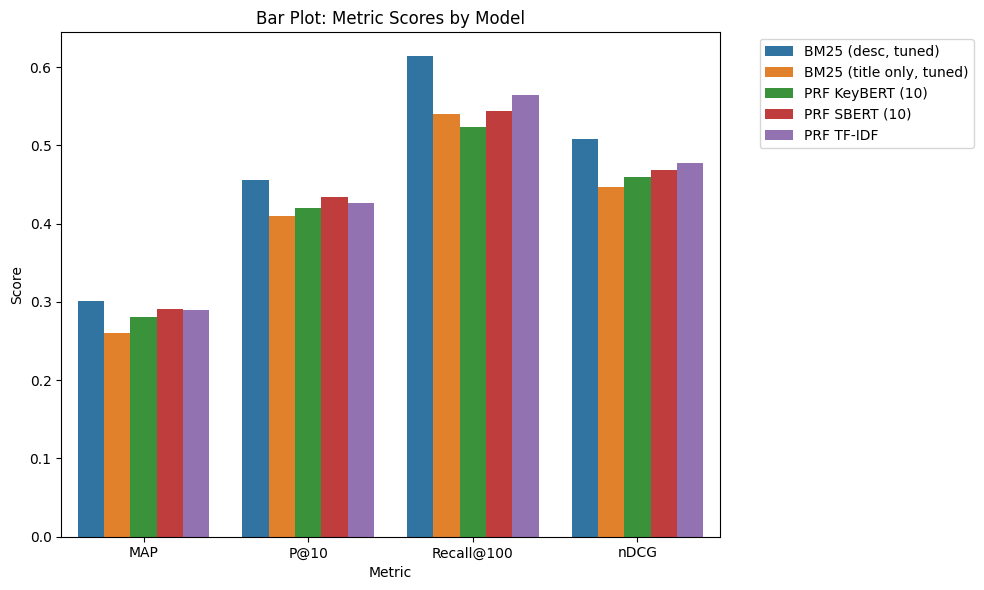

In [ ]:
# Graphics
import matplotlib.pyplot as plt
import seaborn as sns

# Data
data = {
    "Model": [
        "BM25 (desc, tuned)",
        "BM25 (title only, tuned)",
        "PRF KeyBERT (10)",
        "PRF SBERT (10)",
        "PRF TF-IDF"
    ],
    "MAP": [0.301375, 0.26011, 0.281266, 0.290716, 0.29017],
    "P@10": [0.456, 0.41, 0.42, 0.434, 0.426],
    "Recall@100": [0.613607, 0.539969, 0.522922, 0.544269, 0.564452],
    "nDCG": [0.508126, 0.446874, 0.459968, 0.468388, 0.476746]
}




# Data
data = {
    "Model": [
        "BM25 (desc, tuned)",
        "BM25 (title only, tuned)",
        "PRF KeyBERT (10)",
        "PRF SBERT (10)",
        "PRF TF-IDF"
    ],
    "MAP": [0.301375, 0.26011, 0.281266, 0.290716, 0.29017],
    "P@10": [0.456, 0.41, 0.42, 0.434, 0.426],
    "Recall@100": [0.613607, 0.539969, 0.522922, 0.544269, 0.564452],
    "nDCG": [0.508126, 0.446874, 0.459968, 0.468388, 0.476746]
}

df = pd.DataFrame(data)

# Radar Chart Preparation
categories = list(df.columns[1:])
N = len(categories)

# Add first value to close the loop for radar
values_list = [df.loc[i, categories].tolist() + [df.loc[i, categories[0]]] for i in range(len(df))]

# Setup angles for radar chart
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Bar Plot for Each Metric
df_melted = df.melt(id_vars="Model", var_name="Metric", value_name="Score")
plt.figure(figsize=(10, 6))
sns.barplot(x="Metric", y="Score", hue="Model", data=df_melted)
plt.title("Bar Plot: Metric Scores by Model")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



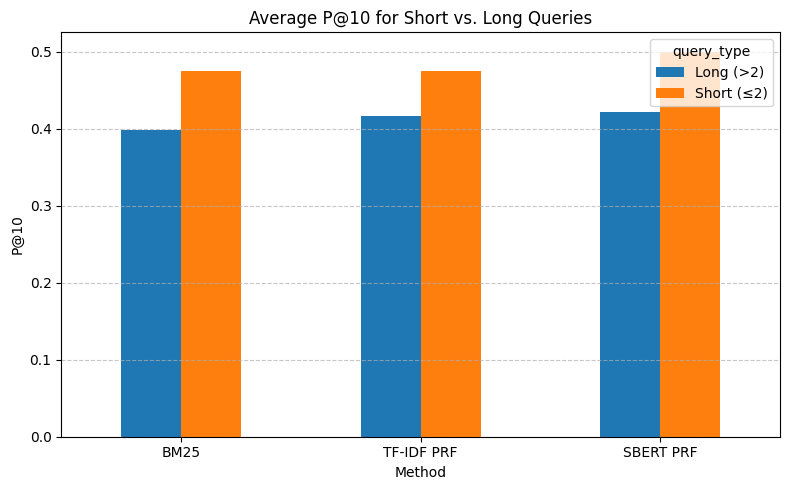

In [ ]:
# Graphics to compare performance of models with short and long queries
tfidf_results = pt.Experiment(
    [bm25_best_for_only_title],
    topics=df_exp_tuned_only_title_only_tfidf,      # qid + query içeren DF
    qrels=qrels,            # qid + docno + relevance
    eval_metrics=["map", "P.10", "recall.100", "ndcg"],
    names=["BM25"],
    perquery=True
)

sbert_results = pt.Experiment(
    [bm25_best_for_only_title],
    topics=df_sbert_exp_tuned_only_title_tfidf,      # qid + query içeren DF
    qrels=qrels,            # qid + docno + relevance
    eval_metrics=["map", "P.10", "recall.100", "ndcg"],
    names=["BM25"],
    perquery=True
)

bm25_results = pt.Experiment(
    [bm25_best_for_only_title],
    topics=queries_df_only_title,      # qid + query içeren DF
    qrels=qrels,            # qid + docno + relevance
    eval_metrics=["map", "P.10", "recall.100", "ndcg"],
    names=["BM25"],
    perquery=True
)
# Convert evaluation results from PyTerrier
bm25_df = pd.DataFrame(bm25_results)
tfidf_df = pd.DataFrame(tfidf_results)
sbert_df = pd.DataFrame(sbert_results)

# Ensure qid is string for consistent merging
bm25_df["qid"] = bm25_df["qid"].astype(str)
tfidf_df["qid"] = tfidf_df["qid"].astype(str)
sbert_df["qid"] = sbert_df["qid"].astype(str)
queries_df_only_title["qid"] = queries_df_only_title["qid"].astype(str)

# Merge with original query text
bm25_df = bm25_df.merge(queries_df_only_title, on="qid")
tfidf_df = tfidf_df.merge(queries_df_only_title, on="qid")
sbert_df = sbert_df.merge(queries_df_only_title, on="qid")

# Add query length and query type classification
for df in [bm25_df, tfidf_df, sbert_df]:
    df["query_len"] = df["query"].apply(lambda q: len(q.split()))
    df["query_type"] = df["query_len"].apply(lambda l: "Short (≤2)" if l <= 2 else "Long (>2)")

# Filter only P@10 scores
bm25_p10 = bm25_df[bm25_df["measure"] == "P.10"]
tfidf_p10 = tfidf_df[tfidf_df["measure"] == "P.10"]
sbert_p10 = sbert_df[sbert_df["measure"] == "P.10"]

# Group by query type and calculate average value
bm25_avg = bm25_p10.groupby("query_type")["value"].mean().rename("BM25")
tfidf_avg = tfidf_p10.groupby("query_type")["value"].mean().rename("TF-IDF PRF")
sbert_avg = sbert_p10.groupby("query_type")["value"].mean().rename("SBERT PRF")

# Combine into one summary table
summary = pd.concat([bm25_avg, tfidf_avg, sbert_avg], axis=1)


ax = summary.T.plot(kind="bar", figsize=(8, 5))
plt.title("Average P@10 for Short vs. Long Queries")
plt.ylabel("P@10")
plt.xlabel("Method")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()